In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from functools import reduce

import subprocess as sp 
from subprocess import Popen
import os

import sys 
sys.path.append('/home/akh/aesthetic/soni/datamovies_y21/modules')

import writeCmixSco_WT_ac as wRT_wt

%matplotlib inline

In [2]:
#load the hydrologic timeseries data. 
#We have precipication at the HJ Andrews Experimental Forest, and then discharge at two tributaries of the Mckenzie with different percentages of upstream young basalt

#Lookout Creek is "old cascades" endmember, with no young rocks in the catchment 
#Clear Lake is the "young cascades" endmember, largely fed by springs from recent lava flows

dfp0 = pd.read_excel ("Precip_HJASite101.xlsx", parse_dates=[7])
#print (df)
print("we have " + str(dfp0.size) + " precip measurements")

dfc0 = pd.read_excel ("ClearLake MRCL_USGS.xls",header=27)
#print (df)
print("we have " + str(dfc0.size) + " data entries (uncorrected discharge) at Clear Lake")

#for this one we use the parse_dates function to combine columnes into a datetime column at the outset! 
dfl0 = pd.read_excel ("LOOKOUT_GSLOOK.xlsx", parse_dates= {"date" : ["year","month","day"]})
#dfl0 = pd.read_excel ("Uncorrected_Discharge/HF00402_LOOKOUT.xlsx",sheet_name='HJA', parse_dates= {"date" : ["year","month","day"]})
#print (df)
print("we have " + str(dfl0.size) + " data entries (uncorrected discharge) at Lookout Ck")

we have 222332 precip measurements
we have 175590 data entries (uncorrected discharge) at Clear Lake
we have 275297 data entries (uncorrected discharge) at Lookout Ck


In [3]:
print(dfp0.head(3))
print(dfc0.head(3))
print(dfl0.head(3))

  DBCODE  ENTITY SITECODE PRECIP_METHOD  HEIGHT QC_LEVEL PROBE_CODE  \
0  MS001       3   CS2MET        PPT101     260       2D   PPTCS201   
1  MS001       3   CS2MET        PPT101     260       2D   PPTCS201   
2  MS001       3   CS2MET        PPT101     260       2D   PPTCS201   

        date  PRECIP_TOT_DAY PRECIP_TOT_FLAG EVENT_CODE  
0 1957-10-01             4.1               A     METHOD  
1 1957-10-02            27.4               A        NaN  
2 1957-10-03            22.9               A        NaN  
  agency_cd   site_no       date  discharge 01_00060_00003_cd
0      USGS  14158500 1912-10-01      256.0                 A
1      USGS  14158500 1912-10-02      254.0                 A
2      USGS  14158500 1912-10-03      252.0                 A
        date STCODE  FORMAT SITECODE  WATERYEAR  MEAN_Q_cfs  MAX_Q  MIN_Q  \
0 1949-10-01  HF004       2   GSLOOK       1950        11.0   11.0   11.0   
1 1949-10-02  HF004       2   GSLOOK       1950        11.0   11.0   11.0   
2 19

In [4]:
#we need to sort the data by data
dfp=dfp0.sort_values(by=['date'])
dfc=dfc0.sort_values(by=['date'])
dfl=dfl0.sort_values(by=['date'])
# rename some of the columns that we will be working with
dfp = dfp.rename(columns={'PRECIP_TOT_DAY': 'HJA Precipitation in mm/day'})
dfc = dfc.rename(columns={'discharge': 'Clear Lake discharge in cfs'})
dfl = dfl.rename(columns={'MEAN_Q_cfs': 'Lookout Ck discharge in cfs'})


#check that the sampling rate is same
dtp = (dfp.date[1] - dfp.date[0])
dtl = (dfl.date[1] - dfl.date[0])
dtc = (dfc.date[1] - dfc.date[0])
print(dtp,dtc,dtl)


1 days 00:00:00 1 days 00:00:00 1 days 00:00:00


2013-01-31 00:00:00
2008-11-23 00:00:00
2018-04-08 00:00:00


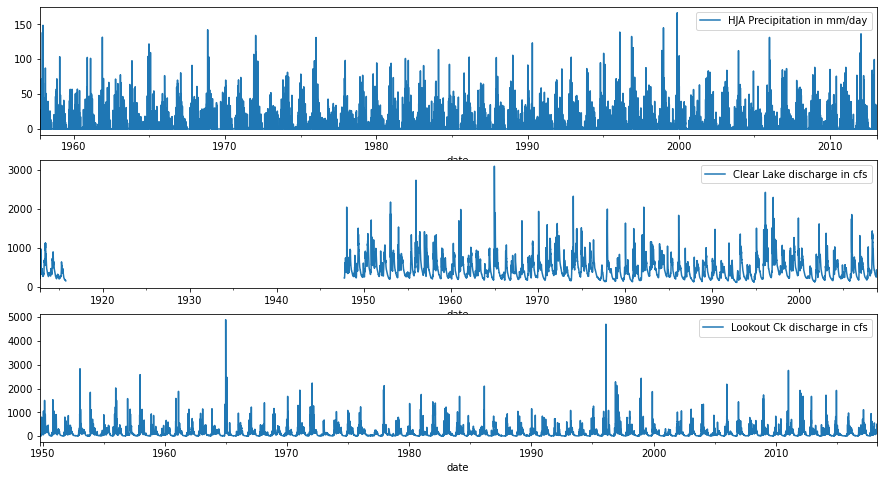

In [33]:
fig,ax = plt.subplots(3,figsize=(15,8));
ax[0]=dfp.plot(x="date", y="HJA Precipitation in mm/day",ax=ax[0]);
ax[1]=dfc.plot(x="date", y="Clear Lake discharge in cfs",ax=ax[1]);
ax[2]=dfl.plot(x="date", y="Lookout Ck discharge in cfs",ax=ax[2]);


#plt.show()
print(dfp['date'].max())
print(dfc['date'].max())
print(dfl['date'].max())

In [6]:
#find common time frame between the datasets
start = '1958-01-01'
end = '2008-01-01'

conditionP = (dfp['date'] > start) & (dfp['date'] <= end)
dp=dfp.loc[conditionP]
conditionL = (dfl['date'] > start) & (dfl['date'] <= end)
dl=dfl.loc[conditionL]
conditionC = (dfc['date'] > start) & (dfc['date'] <= end)
dc=dfc.loc[conditionC]

print(sum(conditionP==True),sum(conditionC==True),sum(conditionL==True))
print(dp.shape[0],dc.shape[0],dl.shape[0])


18262 18262 18262
18262 18262 18262


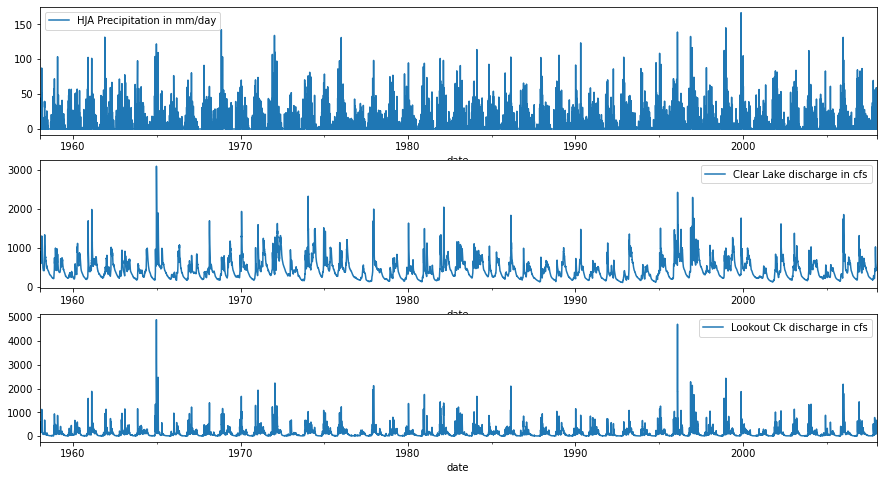

In [7]:
#plot it up
fig,ax = plt.subplots(3,figsize=(15,8));
ax[0]=dp.plot(x="date", y="HJA Precipitation in mm/day",ax=ax[0]);
ax[1]=dc.plot(x="date", y="Clear Lake discharge in cfs",ax=ax[1]);
ax[2]=dl.plot(x="date", y="Lookout Ck discharge in cfs",ax=ax[2]);
fig.savefig('Cascades_Q_Lookout_ClearLake.png')

In [8]:
# compile the list of dataframes we want to merge
data_frames = [dp, dc, dl]
#merge them using the common date column
df_mergedALL = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), data_frames)

#then reduce clutter by making a final dataframe that just has the quantities of interest
df_pcl = df_mergedALL[['date','HJA Precipitation in mm/day', 'Clear Lake discharge in cfs', 'Lookout Ck discharge in cfs']].copy()
df_pcl.head(3)

,date,HJA Precipitation in mm/day,Clear Lake discharge in cfs,Lookout Ck discharge in cfs
0,1958-01-02,3.8,686.0,169.0
1,1958-01-03,0.0,642.0,150.0
2,1958-01-04,0.0,606.0,134.0


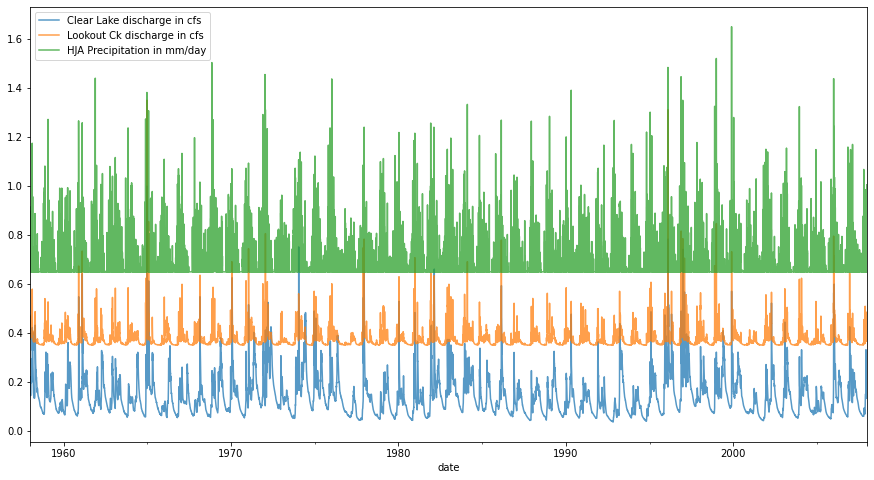

In [9]:
#lets make this a little more readable
#df_norm=(df_pcl-df_pcl.min())/(df_pcl.max()-df_pcl.min())
df_norm=df_pcl.copy()
df_norm["Clear Lake discharge in cfs"] = df_norm["Clear Lake discharge in cfs"]  / df_norm["Clear Lake discharge in cfs"].abs().max()
df_norm["Lookout Ck discharge in cfs"] = df_norm["Lookout Ck discharge in cfs"]  / df_norm["Lookout Ck discharge in cfs"].abs().max() + .35
df_norm["HJA Precipitation in mm/day"] = df_norm["HJA Precipitation in mm/day"]  / df_norm["HJA Precipitation in mm/day"].abs().max() + .65


fig,ax = plt.subplots(figsize=(15,8));
ax=df_norm.plot(x="date", y=["Clear Lake discharge in cfs", "Lookout Ck discharge in cfs", "HJA Precipitation in mm/day"],ax=ax, alpha=0.75);

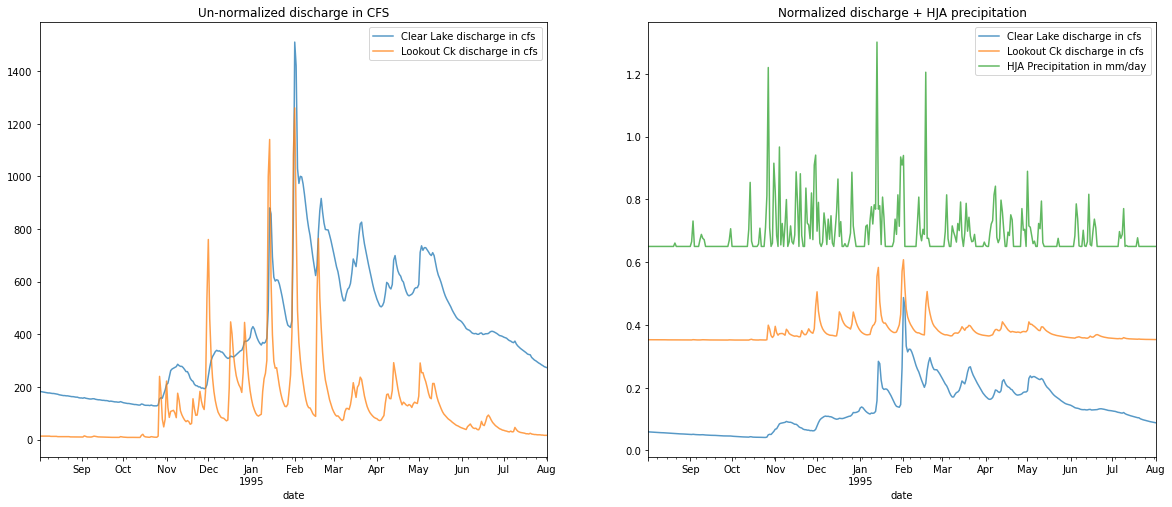

In [10]:
#zoom in a bit to see the details
start2 = '1994-08-01'
end2 = '1995-08-01'
#end2 = '1997-08-01'

condition = (df_norm['date'] > start2) & (df_norm['date'] <= end2)
df_norm2=df_norm.loc[condition]
df_2=df_pcl.loc[condition]

fig,ax = plt.subplots(1,2,figsize=(20,8));
ax[1]=df_norm2.plot(x="date", y=["Clear Lake discharge in cfs", "Lookout Ck discharge in cfs", "HJA Precipitation in mm/day"],ax=ax[1], alpha=0.75);
ax[0]=df_2.plot(x="date", y=["Clear Lake discharge in cfs", "Lookout Ck discharge in cfs"],ax=ax[0], alpha=0.75);

ax[0].title.set_text('Un-normalized discharge in CFS')
ax[1].title.set_text('Normalized discharge + HJA precipitation')

fig.savefig('Cascades_Q_Lookout_ClearLake_norm.png')

In [11]:
## Calculate the dQ

dQLKOT=df_norm2["Lookout Ck discharge in cfs"].diff()
dQLAKE=df_norm2["Clear Lake discharge in cfs"].diff()



59


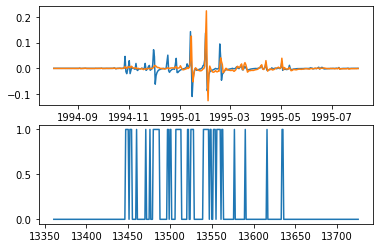

In [12]:
## Calculate the logical of the signs
thres=0.009
dQbydQ1= abs(dQLKOT-dQLAKE-np.mean(dQLKOT)-np.mean(dQLAKE))>thres
dQbydQ2= ~(np.sign(dQLKOT) == np.sign(dQLAKE))

dQbydQ= (dQbydQ1==True) #& (dQbydQ2==True)
fig,ax=plt.subplots(2)
ax[0].plot(df_norm2['date'], dQLKOT)
ax[0].plot(df_norm2['date'], dQLAKE)

ax[1].plot(dQbydQ)

print(np.sum(dQbydQ))

In [13]:
data=np.log10(df_norm2['Lookout Ck discharge in cfs'])

# make an array of integers: 
v=3
k = np.arange(12+1)
print(k)
root=220
print('major scale:')
# intervals 2,2,1,2,2,2,1 
major = np.array([0,2,4,5,7,9,11,12])
print(major)
# Octaves 1,v=0
v=0

f=np.array(root*2**(v+major/12))
for v in [1,2]: # Octaves 2,3,4
    f = np.append(f,root*2**(v+major/12))
print(f)
npitches=len(f)
print(len(f))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
major scale:
[ 0  2  4  5  7  9 11 12]
[ 220.          246.94165063  277.18263098  293.66476792  329.62755691
  369.99442271  415.30469758  440.          440.          493.88330126
  554.36526195  587.32953583  659.25511383  739.98884542  830.60939516
  880.          880.          987.76660251 1108.73052391 1174.65907167
 1318.51022765 1479.97769085 1661.21879032 1760.        ]
24


In [14]:
#now bin and interp
print("Data length", len(data))
notes=len(data)
dur_sound=1/16
dur_score = notes*dur_sound
print("Duration score", dur_score)

tscore=np.linspace(0,dur_score,notes)

Data length 365
Duration score 22.8125


(array([333.,  20.,   5.,   0.,   3.,   0.,   1.,   1.,   1.,   1.]),
 array([ 220.,  374.,  528.,  682.,  836.,  990., 1144., 1298., 1452.,
        1606., 1760.]),
 <BarContainer object of 10 artists>)

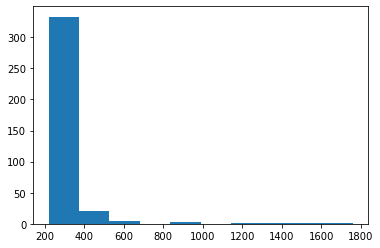

In [15]:
## Bin data 
bins=np.linspace(min(data),max(data), npitches)

p=np.digitize(data,bins)

datapitches=[ f[i-1] for i in p ]

plt.hist(datapitches)

In [16]:
# (4) write RTcmix Wavetable score

base_name = 'test_CFS'

tones_dict = {}
tones_dict['times'] = np.asarray(tscore)
tones_dict['notes'] = np.asarray(datapitches)
tones_dict['durs'] = np.ones(len(datapitches))*dur_sound # the 0.8 makes for more discrete pitches
tones_dict['amps'] = np.ones(len(datapitches))*2000
tones_dict['pans'] = np.ones(len(datapitches))*0.5

score_name = wRT_wt.writesco(tones_dict,base_name)

test_CFS.sco
CMIX found.
rtoutput("test_CFS.wav")



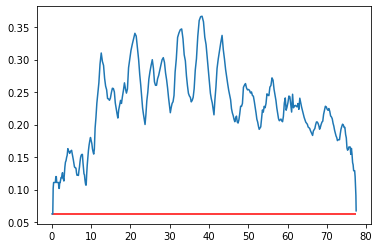

In [17]:
## Now try speeding it up based on dQ 

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

#scale DQ to mean and std
dQ2=(dQLKOT-np.mean(dQLKOT))/np.std(dQLKOT)
threshold=2

#Find moving average to speed it up
dQabs=abs(dQ2)

## smooth it out 



fig,ax=plt.subplots()
scale=1/5

dt=dur_sound*(1+dQabs**(scale)*4)

dt=moving_average(dt, 7) #smooth out
dt=np.array(dt)
dt[np.isnan(dt)]=dur_sound # replace nan
tscore2=np.cumsum(dt)
dt[dt<dur_sound]=dur_sound # get rid of edge effects

ax.plot(tscore2,dt)
ax.hlines(dur_sound, 0, max(tscore2) ,'red')




In [18]:
# (4) write RTcmix Wavetable score

base_name = 'test_CFS_speedup'

print(len(tscore), len(datapitches), len(dt))
tones_dict = {}
tones_dict['times'] = np.asarray(tscore2)
tones_dict['notes'] = np.asarray(datapitches)
tones_dict['durs'] = np.asarray(dt) # the 0.8 makes for more discrete pitches
tones_dict['amps'] = np.ones(len(datapitches))*2000
tones_dict['pans'] = np.ones(len(datapitches))*0.5

score_name = wRT_wt.writesco(tones_dict,base_name)

365 365 365
test_CFS_speedup.sco
CMIX found.
rtoutput("test_CFS_speedup.wav")



In [19]:
## speedupDQ 
def SpeedUpDQ(dQ, scale, dur_sound):

    #scale DQ to mean and std
    dQ2=(dQ-np.mean(dQ))/np.std(dQ)
    threshold=2

    #Find moving average to speed it up
    dQabs=abs(dQ2)
    dt=dur_sound*(1+dQabs**(scale)*4)

    dt=moving_average(dt, 7) #smooth out
    dt=np.array(dt)
    dt[np.isnan(dt)]=dur_sound # replace nan
    tscore=np.cumsum(dt)
    dt[dt<dur_sound]=dur_sound # get rid of edge effects

    return tscore, dt

def freqDigitize(data, root, noctaves,v=0, mode='ionian'):
    
    modes={
        'ionian':[2,2,1,2,2,2,1],
        'dorian':[2,1,2,2,2,1,2],
        'phyrigian':[1,2,2,2,1,2,2],
        'lydian':[2,2,2,1,2,2,1],
        'mix':[2,2,1,2,2,1,2],
        'aeol':[2,1,2,2,1,2,2]
    }
    
    
    data=np.log(data)
    major=np.cumsum(modes[mode])
    f=np.array(root*2**(v+major/12))
    major1=major
    v1=np.zeros(len(major))
    
    for vi in range(1,noctaves):
        print(vi)
        for mi in range(len(major)):
            f = np.append(f, root*2**((vi+v)+major[mi]/12))
            v1=np.append(v1,v)
        major1=np.append(major1, major)
    
    
    npitches=len(f)
    bins=np.linspace(min(data), max(data), npitches)
    p=np.digitize(data, bins)
    datapitches=[f[i-1] for i in p ]
    majortone=[major1[i-1] for i in p]
    octive=[v1[i-1] for i in p]
    
    return datapitches, majortone, octive

In [20]:
def semiToneAddOn(databool, k1, v1, root):

    knew1=k1+0.5
    knew1[knew1>12]=0
    v1[knew1>12]=v1[knew1>12]+1
    s1=root*2**(v1+knew1/12)
    s1=s1[databool]
    return s1

In [21]:
## Speed up based on average of LKOT and LAKE 

dQAvg=(dQLKOT+dQLAKE)/2
scale =1/5
tscore, dt=SpeedUpDQ(dQAvg, scale, dur_sound)

In [22]:
# (4) write RTcmix Wavetable score

base_name = 'test_CFS_speedup'

print(len(tscore), len(datapitches), len(dt))
tones_dict = {}
tones_dict['times'] = np.asarray(tscore)
tones_dict['notes'] = np.asarray(datapitches)
tones_dict['durs'] = np.asarray(dt) # the 0.8 makes for more discrete pitches
tones_dict['amps'] = np.ones(len(datapitches))*2000
tones_dict['pans'] = np.ones(len(datapitches))*0.5

score_name = wRT_wt.writesco(tones_dict,base_name)

365 365 365
test_CFS_speedup.sco
CMIX found.
rtoutput("test_CFS_speedup.wav")



In [31]:
rootLKOUT=349.23
rootLAKE=261.63
notelength=1/2

pitchesLKOUT, k1,v1=freqDigitize(df_norm2['Lookout Ck discharge in cfs'], 349.23, 3, mode='lydian')
pitchesLAKE, k2,v2=freqDigitize(df_norm2['Clear Lake discharge in cfs'], 261.63, 3)
df=pd.DataFrame({"pitches":pitchesLKOUT})
df.to_csv("LOOKOUT_PITCHES.csv")

pitches=np.append(pitchesLKOUT, pitchesLAKE)

tscore1=np.linspace(0, len(pitches)*(notelength)/2, int(len(pitches)/2))
tscore=np.tile(tscore1,2)



1
2
1
2


In [28]:
# (4) write RTcmix Wavetable score

base_name = 'test_CFS_both'


print(len(tscore), len(pitches))
tones_dict = {}
tones_dict['times'] = np.asarray(tscore)
tones_dict['notes'] = np.asarray(pitches)
tones_dict['durs'] = np.ones(len(pitches))*(notelength) # the 0.8 makes for more discrete pitches
tones_dict['amps'] = np.ones(len(pitches))*2000
tones_dict['pans'] = np.ones(len(pitches))*0.5

score_name = wRT_wt.writesco(tones_dict,base_name)

730 730
test_CFS_both.sco
CMIX found.
rtoutput("test_CFS_both.wav")



365


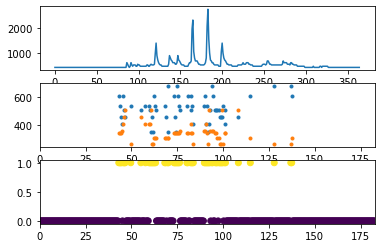

59
59


In [29]:
s1=semiToneAddOn(dQbydQ, np.array(k1), np.array(v1), rootLKOUT)
s2=semiToneAddOn(dQbydQ,  np.array(k2), np.array(v2), rootLAKE)

fig,ax=plt.subplots(3)
ax[0].plot(pitchesLKOUT)
ax[1].plot(tscore1[dQbydQ==1],s1, '.')
ax[1].plot(tscore1[dQbydQ==1], s2, '.')
ax[1].set_xlim([0,len(pitches)*notelength*.5])
ax[2].set_xlim([0, len(pitches)*notelength*.5])
ax[2].scatter(tscore1, dQbydQ, c=dQbydQ)
print(len(pitchesLKOUT))
plt.show()

tscore_ALL1=np.append(tscore, tscore1[dQbydQ])
tscore_ALL=np.append(tscore_ALL1,tscore1[dQbydQ])
pitches1=np.append(pitches, s1)
pitches3=np.append(pitches1,s2)
print(len(s1))
print(len(s2))

#print(max(pitchesLKOUT[dQbydQ]))

In [30]:
# (4) write RTcmix Wavetable score

base_name = 'test_CFS_disohalf'

print(len(tscore_ALL), len(pitches3))
tones_dict = {}
tones_dict['times'] = np.asarray(tscore_ALL)
tones_dict['notes'] = np.asarray(pitches3)
tones_dict['durs'] = np.ones(len(pitches3))*notelength*.8 # the 0.8 makes for more discrete pitches
tones_dict['amps'] = np.ones(len(pitches3))*2000
tones_dict['pans'] = np.ones(len(pitches3))*0.5

score_name = wRT_wt.writesco(tones_dict,base_name)

848 848
test_CFS_disohalf.sco
CMIX found.
rtoutput("test_CFS_disohalf.wav")

